In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [40]:
import numpy as np
from scipy.spatial import distance
from scipy.optimize import minimize
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

### Define General Setting

In [5]:
d = 100
N = 10

In [6]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [7]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

X_train = torch.DoubleTensor(X_train)
X_test = torch.DoubleTensor(X_test)
y_train = torch.DoubleTensor(y_train)
y_test = torch.DoubleTensor(y_test)

In [8]:
y_train.shape, X_train.shape

(torch.Size([10]), torch.Size([10, 100]))

### Define FC Model

In [9]:
def symmetric_init(alpha, s, m, d, symmetric=True):
    """
    alpha = |a_0| + ||w_0||
    s = (|a_0| - ||w_0||) / (|a_0| + ||w_0||)
    """
    norms_w = []
    norms_a = []
    for alpha_i, s_i in zip(alpha, s):
        norm_w = np.sqrt(alpha_i * (1 - s_i) / (1 + s_i))
        norm_a = np.sqrt(alpha_i * (1 + s_i) / (1 - s_i))
        norms_w.append(norm_w)
        norms_a.append(norm_a)

    w_0 = np.random.normal(size=(m, d), loc=0, scale=1)
    w_0_norms = np.linalg.norm(w_0, axis=1, ord=2)
    w_0 = w_0 / w_0_norms[:, np.newaxis] * np.array(norms_w)[:, np.newaxis]

    a_0 = np.random.normal(size=(1, m), loc=0, scale=1)
    a_0 = np.multiply(np.ones_like(a_0) * np.array(norms_a), (1 * (a_0 > 0) - 0.5) * 2)

    if symmetric:
        w_0[m // 2:, :] = w_0[:m // 2, :]
        a_0[:, m // 2:] = -a_0[:, :m // 2]

    return w_0.transpose(), a_0.reshape(-1,)

In [66]:
class TwoLayerModel(nn.Module):
    def __init__(self, alpha, s, m, d, use_relu=False, symmetric=True):
        super(TwoLayerModel, self).__init__()

        self.w = nn.Parameter(torch.DoubleTensor(d, m))
        self.a = nn.Parameter(torch.DoubleTensor(m))

        if use_relu:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

        with torch.no_grad():
            # unbiased init
            w_0, a_0 = symmetric_init([alpha] * m, [s] * m, m, d, symmetric=symmetric)
            self.w.data, self.a.data = torch.DoubleTensor(w_0), torch.DoubleTensor(a_0)
            self._w_tilde_0 = (self.w.transpose(1, 0) * self.a.view(-1, 1)).detach().numpy()

    def forward(self, x):
        x = torch.matmul(x, self.w)
        x = self.activation(x)
        x = torch.mv(x, self.a)
        return x
    
    @property
    def w_tilde(self):
        """ w_tilde \in R^[m x d]"""
        return (self.w.transpose(1, 0) * self.a.view(-1, 1)).detach().numpy()


    @property
    def w_tilde_0(self):
        return self._w_tilde_0
    
    
def train(alpha, s, m, d, step_size, use_relu=False, symmetric=True, early_stop_tol=1e-5, num_epochs=int(1e7)):
    model = TwoLayerModel(alpha=alpha, s=s, m=m, d=d, use_relu=use_relu, symmetric=symmetric)
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    w_tilde_array = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)
        loss.backward()
        optimizer.step()

        w_tilde_array.append(model.w_tilde)
        if loss.item() < early_stop_tol:
            print(f'early stopping after {epoch + 1} epochs')
            break

    with torch.no_grad():
        test_loss = F.mse_loss(model(X_test), y_test)
    return model, loss, test_loss, w_tilde_array

### Define Q Function

$q\left(\mathbf{\tilde{w}}(t)\right)=\frac{\left(\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}-\frac{\delta}{2}\left(\frac{\delta}{2}+\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}\right)\right)\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}}{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert }-\frac{3}{2}\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}\frac{\mathbf{\tilde{w}}^{\top}(0)}{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert }\mathbf{\tilde{w}}(t)$

In [67]:
def q(w_i, w_i_0, delta_i):
    d = delta_i/2
    norm_w_i = np.linalg.norm(w_i, ord=2)
    norm_w_i_0 = np.linalg.norm(w_i_0, ord=2)
    
    return (1/norm_w_i) * (norm_w_i**2 - d * (d + np.sqrt(norm_w_i**2 + d**2))) * np.sqrt(np.sqrt(norm_w_i**2 + d**2) - d)\
        - (3/2) * np.sqrt(np.sqrt(norm_w_i_0**2 + d**2) - d) * np.matmul(w_i_0.transpose(), w_i) / norm_w_i_0

In [201]:
def Q(w, w_0, delta):
    f = 0
    for w_i, w_i_0, delta_i in zip(w, w_0, delta):
        f += q(w_i, w_i_0, delta_i)
    return f

In [202]:
def flatten(w_tilde):
    return w_tilde.flatten()

def restore(w_tilde, m, d):
    return w_tilde.reshape(m, d)

In [229]:
def constraint(v, x, y, m, d, optim_tol):
    w_tilde = restore(v, m, d)
    return optim_tol - np.abs(np.matmul(w_tilde, x.transpose()).sum(axis=0) - y).reshape(-1, )

def solver(x, y, w_tilde_0, alpha, s, obj='L1', optim_tol=1e-5, x_0=None):
    x0 = w_tilde_0
    if x_0 is not None:
        x0 = x_0

    cons = {'type': 'ineq', 'fun': lambda v: constraint(v, x, y, m, d, optim_tol)}

    if obj == 'L1':
        objective = lambda v: np.linalg.norm(v, ord=2)
    elif obj == 'Q':
        delta = [4 * alpha * s / (1 - s**2)] * m
        objective = lambda v: Q(restore(v, m, d), w_tilde_0, delta)
    else:
        raise ValueError('objective not supported.')

    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': False
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return restore(sol.x, m, d)

### Sanity Check (Linear Single Neuron)

In [280]:
m = 1
alpha = 1
s = 0.5

In [281]:
model, train_loss, test_loss, w_tilde_array = train(alpha=alpha, s=s, m=m, d=d, step_size=1e-3, symmetric=False)
train_loss.item(), test_loss.item()

early stopping after 142 epochs


(9.515334731042119e-06, 1.490301967311696)

In [282]:
w_tilde_Q = solver(X_train.numpy(), y_train.numpy(), model.w_tilde_0, alpha=alpha, s=s, obj='Q')

In [283]:
distance.cosine(w_tilde_Q.flatten(), model.w_tilde.flatten())

8.637777078046582e-07

Text(0.5, 0, 'epoch')

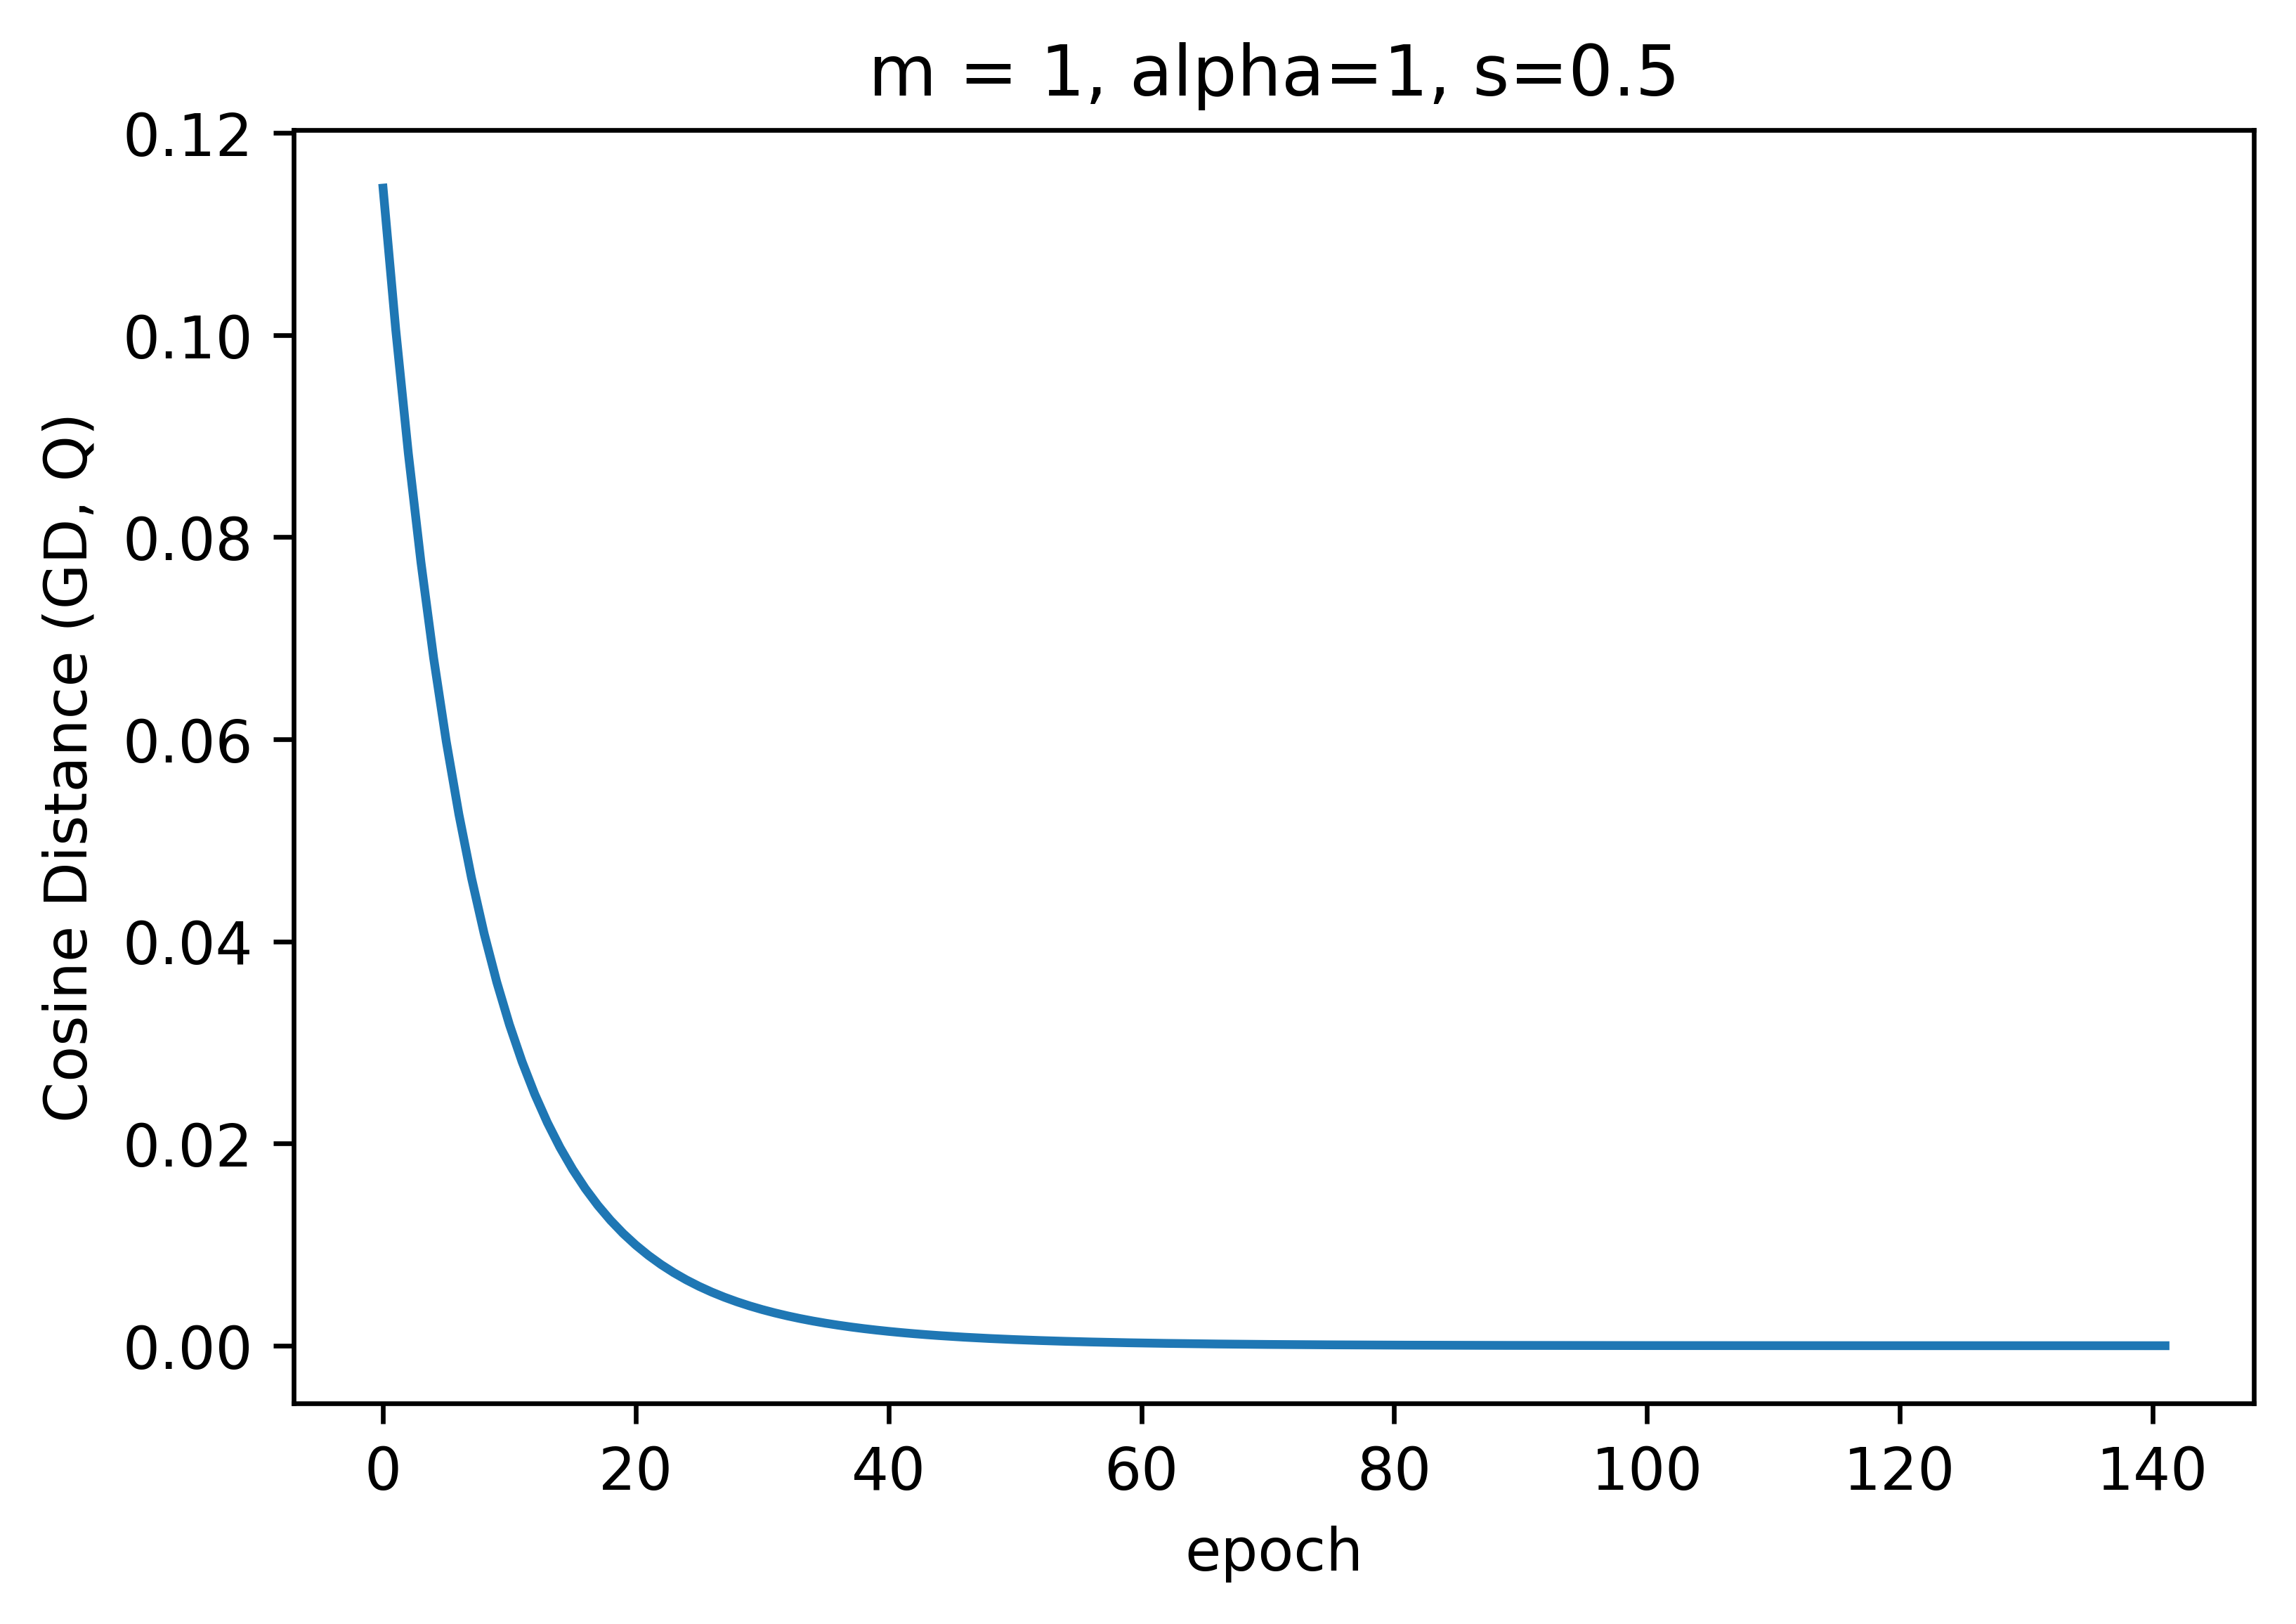

In [285]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')

### Linear Multi Neuron

In [273]:
m = 3
alpha = 0.1
s = 0.5

In [274]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha, 
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3, 
    symmetric=False
)
train_loss.item(), test_loss.item()

early stopping after 435 epochs


(9.911241548540984e-06, 0.9397288796518969)

In [275]:
w_tilde_Q = solver(X_train.numpy(), y_train.numpy(), model.w_tilde_0, alpha=alpha, s=s, obj='Q')

In [276]:
distance.cosine(w_tilde_Q.flatten(), model.w_tilde.flatten())

5.44371761890261e-06

Text(0.5, 0, 'epoch')

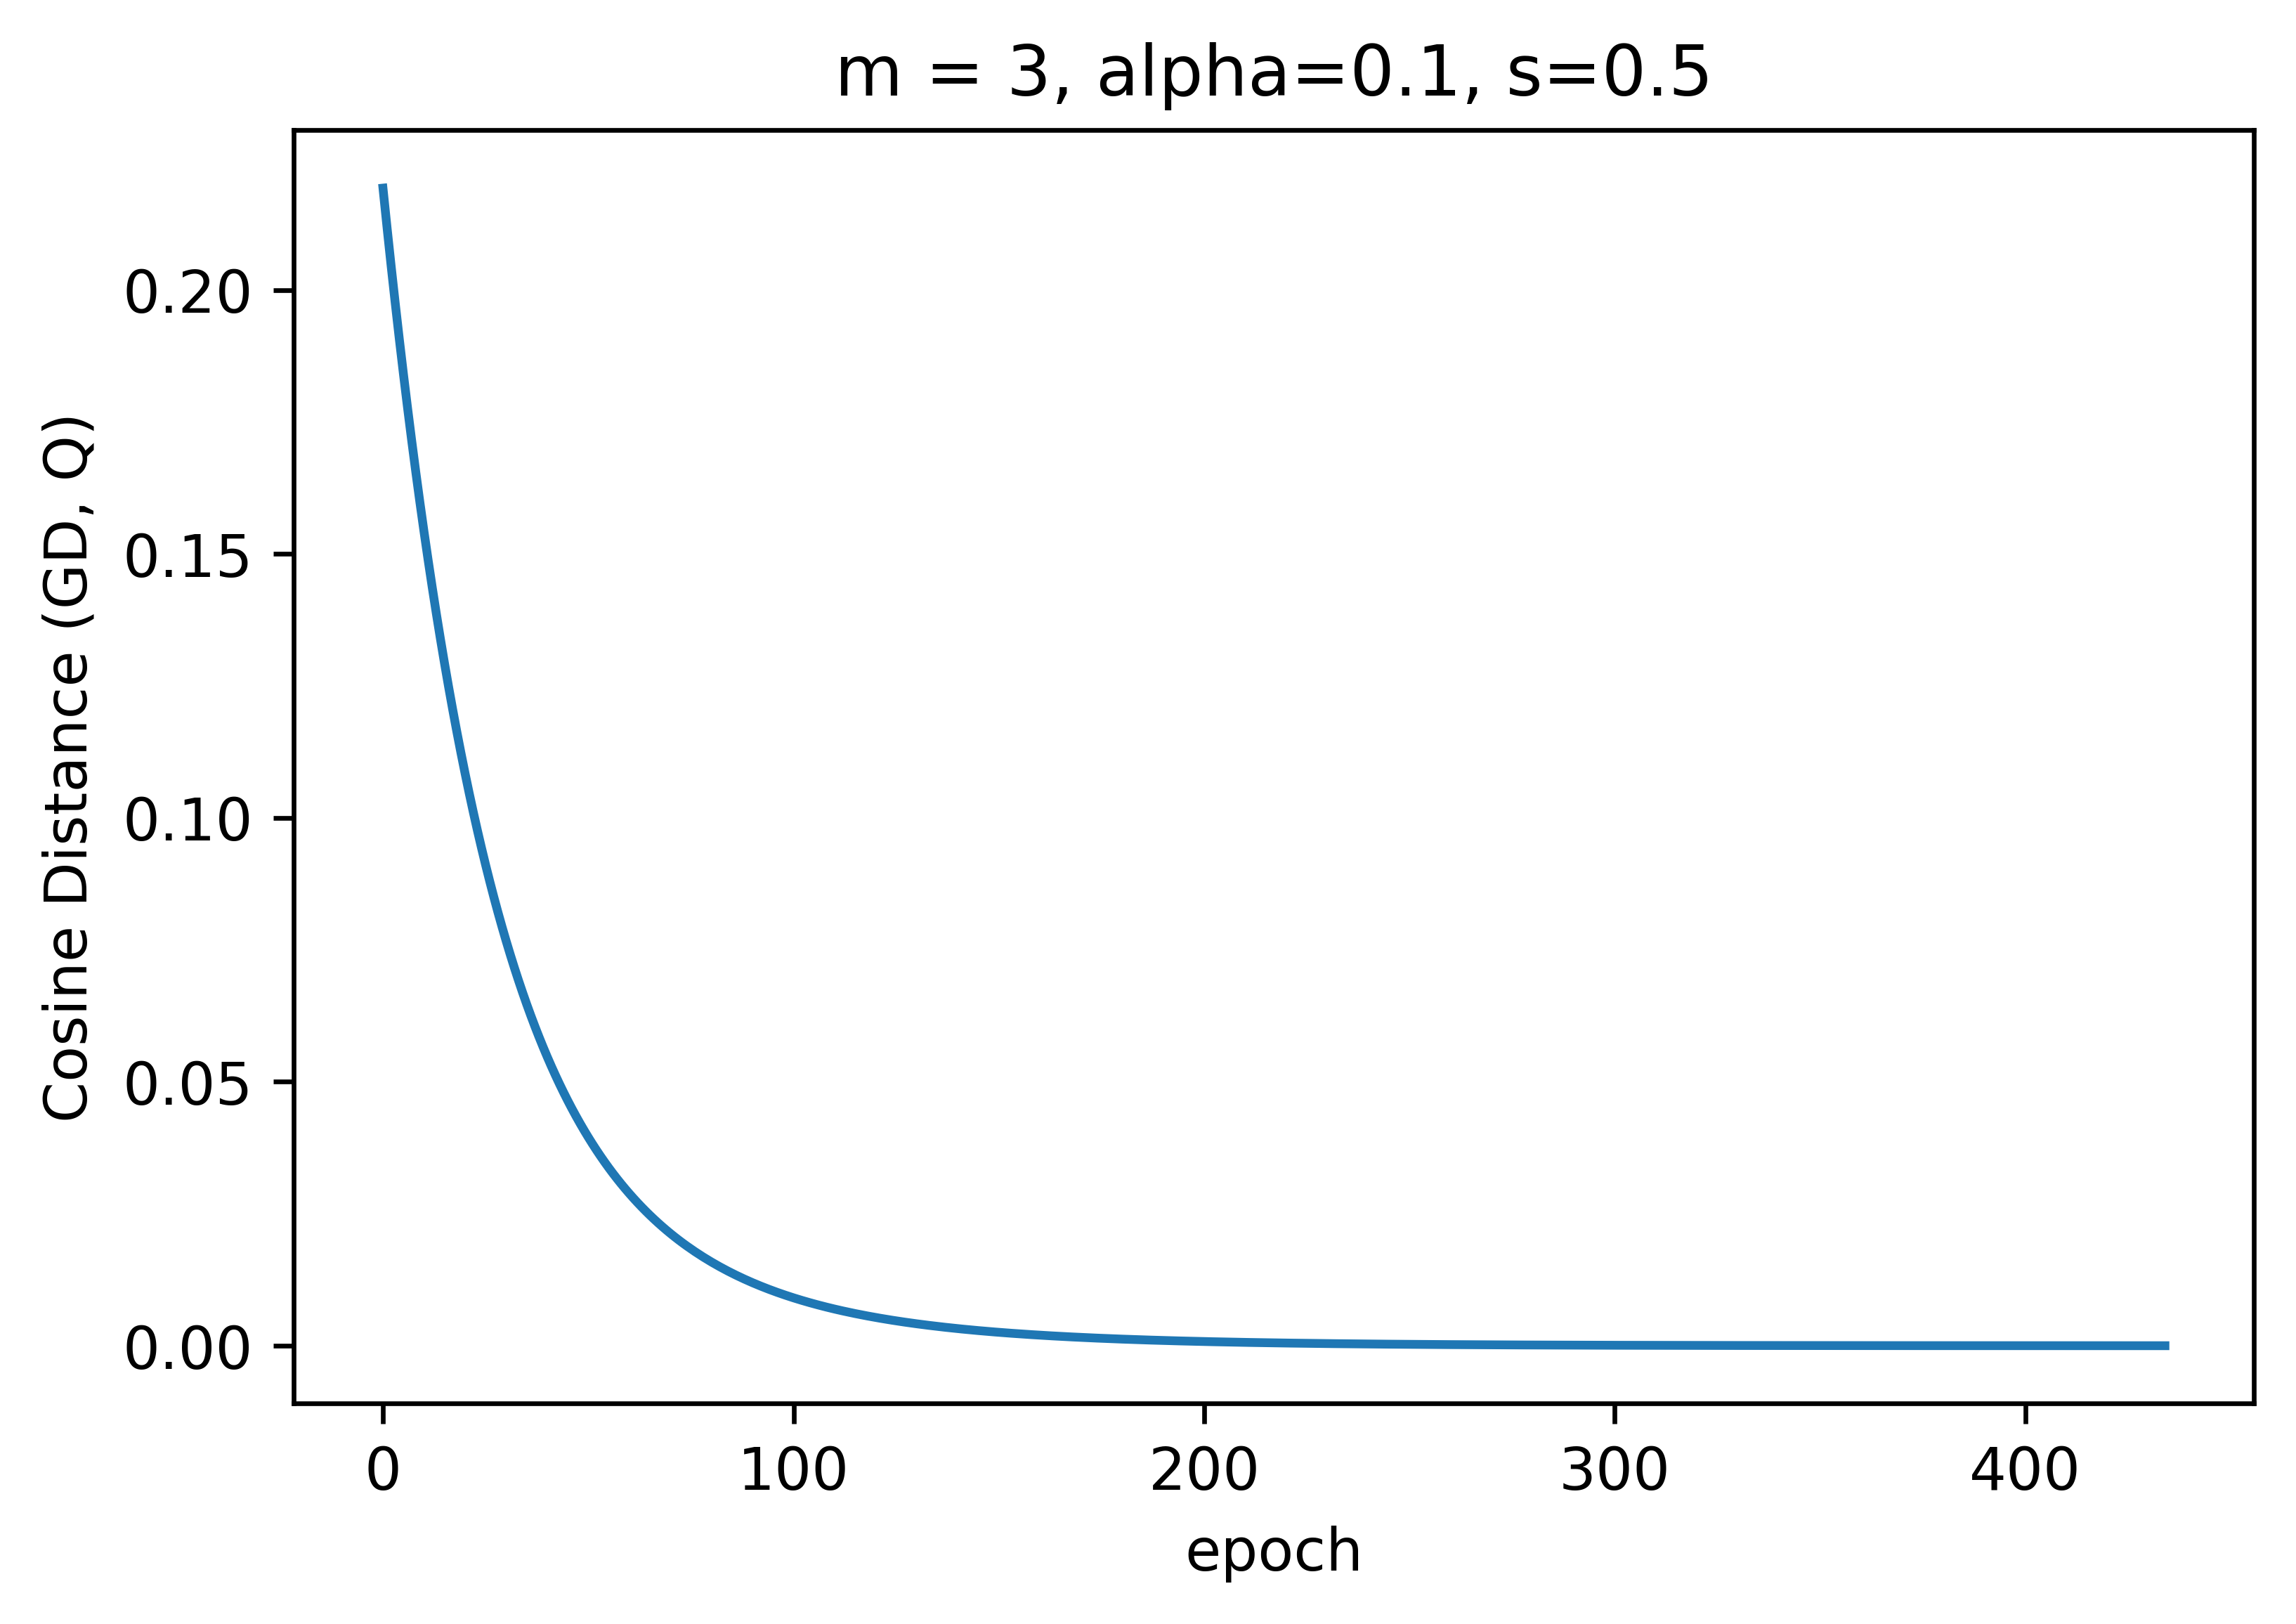

In [278]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')